In [1]:
from util import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
import random, os, time, faiss

## Setup directories

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']= '3'
# input_file
kgtk_wordnet = "./data/wn/kgtk_wordnet.tsv"

# ouput_file
wn_entity_file = "./data/wn/entities.txt"
wn_entity2text_file = "./data/wn/entity2text.txt"
wn_relation_file = "./data/wn/relations.txt"
wn_relation2text_file = "./data/wn/relation2text.txt"
wn_train = "./data/wn/train.tsv"
wn_dev = "./data/wn/dev.tsv"
wn_test = "./data/wn/test.tsv"
wn_MRS_rank = "./data/wn/mrs_rank.txt"
wn_MFS_rank = "./data/wn/mfs_rank.txt"
wn_STB_rank = "./data/wn/stb_rank.txt"
wn_STR_rank = "./data/wn/str_rank.txt"

## Data Preperation

In [4]:
def sent_generation(label1, rela_label, label2):
    return label1 + " "+rela_label+" "+label2

def generate_gold_file(lines):
    # Generate TSV file for relation classification
    wn_gold_all = []
    i = 0
    for line in lines:
        node1_id = line[0]
        relation_id = line[1]
        node2_id = line[2]
        node1_labels = line[3]
        node2_labels = line[4]
        relation_label = line[5].replace('"',"")

        # modeify the node labels, check with leve distance
        node1_label = multiple_labels(node1_labels,node1_id)
        node2_label = multiple_labels(node2_labels,node2_id)

        wn_gold_all.append([node1_label, relation_label, node2_label, node1_id, node2_id,relation_id])
        i += 1
        if i%10000==0:
            print(f"\r {i}/{len(lines)}", end="")
        
    return wn_gold_all

def write_file(filename, lines, head=False,head_content="", encoding="UTF-8", delimiter="\t"):
    # write file
    with open(filename, "w", newline='') as f:
        writer = csv.writer(f, delimiter=delimiter)
        if head:
            writer.writerow(head_content)
        writer.writerows(lines)
        
def write_split_file(filename1,lines,entity2detail,relation2detail):
    # write train & train2 id
    with open(filename1,"w",newline='') as f1:
        w1 = csv.writer(f1, delimiter='\t')

        for line in lines:
            # wtite content
            entity1, relation, entity2 = line
            w1.writerow([entity1,relation,entity2])

In [5]:
# load data
head, lines = load_file(kgtk_wordnet)

In [6]:
# triple example
lines[0]

['wn:physical_entity.n.01',
 '/r/IsA',
 'wn:entity.n.01',
 '"physical entity"',
 '"entity"',
 '"is a"',
 '',
 '"WN"']

**Data Description**

Obtain some basic information of dataset:

In [7]:
# generate gold line
wn_gold = generate_gold_file(random.choices(lines, k=10000))

 10000/10000

In [8]:
# example of gold line
wn_gold[0]

['furan',
 'is a',
 'organic compound',
 'wn:furan.n.01',
 'wn:organic_compound.n.01',
 '/r/IsA']

In [9]:
# check whether it has triplr without predicate
# if yes, remove this triples
# check number of relations, unique nodes, total edges, distribution of relations, most frequent nodes

unique_nodes = dict()
relations_dict = dict()

node2text = dict()
relation2text = dict()

for line in wn_gold:
    node1_id = line[3]
    node2_id = line[4]
    relation_id = line[5]
    
    node1_label = line[0]
    node2_label = line[2]
    relation_label = line[1]
    
    # count the number of unique nodes
    unique_nodes[node1_id] = unique_nodes.get(node1_id,0)+1
    unique_nodes[node2_id] = unique_nodes.get(node2_id,0)+1
    
    # count the number of unique relations
    relations_dict[relation_id] = relations_dict.get(relation_id,0)+1
    
    node2text[node1_id] = node1_label
    node2text[node2_id] = node2_label
    relation2text[relation_id] = relation_label
    
# Summary
print(f"The number of triples: {len(lines)}")
print(f"The number of unique nodes: {len(unique_nodes)}")
print(f"The number of unique relations: {len(relations_dict)}")
max_fre_nodes = max(unique_nodes, key=unique_nodes.get)
print(f"The most frequent node: {max_fre_nodes}")
max_fre_relation = max(relations_dict, key=relations_dict.get)
print(f"The most frequent relation: {max_fre_relation}")

The number of triples: 111276
The number of unique nodes: 14912
The number of unique relations: 3
The most frequent node: wn:herb.n.01
The most frequent relation: /r/IsA


(array([1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]),
 array([  74. ,  868.4, 1662.8, 2457.2, 3251.6, 4046. , 4840.4, 5634.8,
        6429.2, 7223.6, 8018. ]),
 <BarContainer object of 10 artists>)

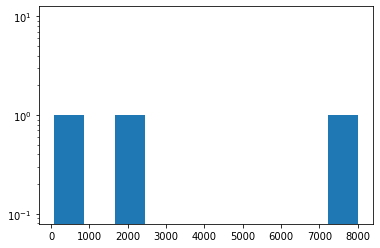

In [10]:
plt.hist(relations_dict.values(),log=True)

In [14]:
def entity_index_find(wn_gold):
    idxs = []
    for line in wn_gold:
        
        entity1=line[3]
        entity2=line[4]
        
        entity1_label = line[0].replace('"',"")
        entity2_label = line[2].replace('"',"")
        
        entity1_wn = wn.synset(entity1.split(":")[1])
        entity2_wn = wn.synset(entity2.split(":")[1])
        
        candidates1 = generate_candidates(entity1_label)
        candidates2 = generate_candidates(entity2_label)
        

        temp1 = candidates1.index(entity1_wn)
        temp2 = candidates2.index(entity2_wn)
        
        idxs.append(temp1)
        idxs.append(temp2)
    
    max_ = 1
    freq_ = 0
    
    freq_accuracy = dict()
    while freq_ <= max_:
        temp = 0
        for idx in idxs:
            max_ = max(idx, max_)
            
            if idx == freq_:
                temp +=1
        
        freq_accuracy[freq_] = temp/len(idxs)
        
        freq_ += 1
    return freq_accuracy

In [15]:
freq_accuracy = entity_index_find(wn_gold)

<BarContainer object of 72 artists>

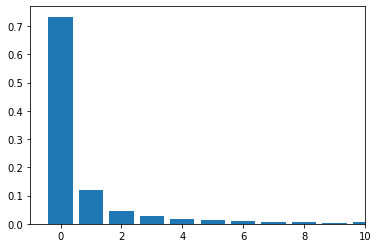

In [21]:
plt.xlim((-1,10))
plt.bar(freq_accuracy.keys(), freq_accuracy.values())

**Generate Data File**

Generate Data File for Kg-Bert Prediction (train, dev, test)

In [10]:
entity2detail = dict()
relation2detail = dict()

for node_id in unique_nodes:
    # build dict for each entity with their id, text, and long text
    definition = wn.synset(node_id.split(":")[1]).definition()
    entity_label = node2text[node_id]
    entity2detail[node_id]=[entity_label, definition]

idx = 0
for relation_id in relation2text:
    # build dict for each relation with their id, text, and long text
    relation_label = relation2text[relation_id]
    relation2detail[relation_id]=[relation_label]
    idx += 1
    
# Transfer gold data to the structure of kg-bert
kgBert_data = [[_[3],_[5],_[4],sent_generation(_[0],_[1],_[2])] for _ in wn_gold]

In [11]:
# write file
# entities.txt, entity2id, entity2text, entity2textlong

with open(wn_entity_file,"w",newline='') as f1,open(wn_entity2text_file, "w",newline='') as f2:
    w1 = csv.writer(f1, delimiter='\t')
    w2 = csv.writer(f2, delimiter='\t')
    
    for entity in entity2detail:
        # wtite content
        entity_text, entity_textlong = entity2detail[entity]
        w1.writerow([entity,])
        w2.writerow([entity,entity_textlong])
        
# relations.txt, rekation2id.txt, relation2text.txt
with open(wn_relation_file,"w",newline='') as f1, open(wn_relation2text_file, "w",newline='') as f2:
    w1 = csv.writer(f1, delimiter='\t')
    w2 = csv.writer(f2, delimiter='\t')

    for relation in relation2detail:
        # wtite content
        relation_text = relation2detail[relation][0]
        w1.writerow([relation,])
        w2.writerow([relation,relation_text])

In [12]:
# Split train, dev, test file

random.shuffle(kgBert_data)

# define ratio of train, dev, test
train_ratio = 0.8
dev_ratio = 0.1
test_ratio = 1 - train_ratio - dev_ratio

len_gold = len(kgBert_data)
train, dev, test = np.split(kgBert_data,[int(train_ratio*len_gold),int((train_ratio+dev_ratio)*len_gold)])
print("length of train, dev, test: ", len(train), len(dev), len(test))

# write train & train2id
write_split_file(wn_train,[_[0:-1] for _ in train],entity2detail,relation2detail)

# write dev & dev2id
write_split_file(wn_dev,[_[0:-1] for _ in dev],entity2detail,relation2detail)

# write test & test2id
write_split_file(wn_test,[_[0:-1] for _ in test],entity2detail,relation2detail)

length of train, dev, test:  8000 1000 1000


In [13]:
#example of gold file
train[0]

array(['wn:airhead.n.02', '/r/IsA', 'wn:bridgehead.n.01',
       'airhead is a bridgehead'], dtype='<U79')

## Baseline Running

**Random Baseline**

In [15]:
def transfer_words(label):
    # accoording to the labels, generate label that can be recognized by wn interface from NLTK
    idx_list = [x for x, v in enumerate(label) if v == ' ']
    
    if not idx_list:
        #no whitespace in words
        yield label
    else:
        # whitespace in words
        combs = permu(len(idx_list))
        for comb in combs:
            for idx, status, in zip(idx_list, comb):
                if status:
                    label = replace_str(label, "-", idx)
                else:
                    label = replace_str(label, "_", idx)
            yield label
            
def generate_synsets(labels):
    # According to the generation of labels, obtain the synsets
    for label in labels:
        synsets = list(wn.synsets(label))
        
        if synsets:
            return synsets, label
        
    return [], label

def generate_candidates(label):
    candidates,_ = generate_synsets(transfer_words(label))
    return candidates

def shuffle_candidates(candits):
    if candits:
        # random choose candidates
        random.shuffle(candits)
    else:
        return []
    return candits

def rank_check(predict_label, actual_label):
    try:
        idx = predict_label.index(actual_label)
    except ValueError:
        idx=-1
    return idx

def MRS(wn_gold):
    # Random Baseline calculation
    # only predict subject
    wn_predict = []
    for line in wn_gold:
        entity1_label = line[3]
        entity2_label = line[4]
        
        # generate all possible combination of "_"&"-" and check whether it can find sysets.
        # if the combination can generate sysets, use this combinations to generate candidates
        candidates1 = generate_candidates(entity1_label)
        candidates2 = generate_candidates(entity2_label)
        
        candidates1=shuffle_candidates(candidates1)
        candidates2=shuffle_candidates(candidates2)
        
        wn_predict.append([candidates1, line[1], candidates2])
        
    return wn_predict
    
def modify_data(lines,entity2detail):
    # add label in the dataset used to make prediction
    for line in lines:
        entity1, relation, entity2, sent = line
        entity1_label = entity2detail[entity1][0]
        entity2_label = entity2detail[entity2][0]
        yield entity1, relation, entity2, entity1_label,entity2_label, sent

def validation(wn_predict, wn_gold):
    # valid the rank of prediction
    rank_left = []
    rank_right = []
    
    for predict, actual in zip(wn_predict, wn_gold):
        predict_label1 = predict[0]
        actual_label1 = wn.synset(actual[0].split(":")[1].replace(" ","_"))
        
        predict_label2 = predict[2]
        actual_label2 = wn.synset(actual[2].split(":")[1].replace(" ","_"))
        
        rank_left.append(rank_check(predict_label1,actual_label1))
        rank_right.append(rank_check(predict_label2,actual_label2))
        
    return rank_left,rank_right

def rank_accuracy(ranks):
    # check the accuracy for different hits
    max_dep = 1
    threshold = 0
    accuracy_dict = dict()
    ite = 0
    
    while threshold <= max_dep and ite <500:
        for rank in ranks:
            max_dep = max(max_dep, rank)
            if rank <= threshold:
                accuracy_dict[threshold] = accuracy_dict.get(threshold,0)+1
                
        accuracy_dict[threshold] = accuracy_dict[threshold]/len(ranks)
        threshold += 1
        ite += 1
    return accuracy_dict

def save_rank_file(rank1,rank2,filename):
    with open(filename,"w") as f:
        for item1, item2 in zip(rank1,rank2):
            f.write(str(item1)+"\t"+str(item2)+"\n")
    return

In [16]:
# modify train, dev, test data
train_modify = list(modify_data(train,entity2detail))
dev_modify = list(modify_data(dev,entity2detail))
test_modify = list(modify_data(test,entity2detail))

In [17]:
#example of modified train
train_modify[0]

('wn:airhead.n.02',
 '/r/IsA',
 'wn:bridgehead.n.01',
 'airhead',
 'bridgehead',
 'airhead is a bridgehead')

In [18]:
#train dataset
wn_ran_train_predict = MRS(train_modify)
rank_left,rank_right = validation(wn_ran_train_predict, train_modify)
print("Accuracy of left entity train dataset (random baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity train dataset (random baseline): ", rank_accuracy(rank_right)[0])

#dev dataset
wn_ran_dev_predict = MRS(dev_modify)
rank_left,rank_right = validation(wn_ran_dev_predict, dev_modify)
print("Accuracy of left entity dev dataset (random baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity dev dataset (random baseline): ", rank_accuracy(rank_right)[0])

#test dataset
wn_ran_test_predict = MRS(test_modify)
rank_left,rank_right = validation(wn_ran_test_predict, test_modify)
print("Accuracy of left entity test dataset (random baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity test dataset (random baseline): ", rank_accuracy(rank_right)[0])

#save test result
save_rank_file(rank_left,rank_right,wn_MRS_rank)

# accuracy chang with different hits
left_mrs_accuracy=rank_accuracy(rank_left)
right_mrs_accuracy=rank_accuracy(rank_right)

Accuracy of left entity train dataset (random baseline):  0.7155
Accuracy of right entity train dataset (random baseline):  0.59425
Accuracy of left entity dev dataset (random baseline):  0.698
Accuracy of right entity dev dataset (random baseline):  0.595
Accuracy of left entity test dataset (random baseline):  0.715
Accuracy of right entity test dataset (random baseline):  0.6


**MFS Baseline**

In [19]:
def MFS(wn_gold):
    # Frequent Baseline Calculation
    wn_predict = []
    for line in wn_gold:
        entity1_label = line[3]
        entity2_label = line[4]
        
        # generate all possible combination of "_"&"-" and check whether it can find sysets.
        # if the combination can generate sysets, use this combinations to generate candidates
        candidates1 = generate_candidates(entity1_label)
        candidates2 = generate_candidates(entity2_label)
        
        wn_predict.append([candidates1, line[1], candidates2])
        
    return wn_predict

In [20]:
#train dataset
wn_ran_train_predict = MFS(train_modify)
rank_left,rank_right = validation(wn_ran_train_predict, train_modify)
print("Accuracy of left entity train dataset (Frequency baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity train dataset (Frequency baseline): ", rank_accuracy(rank_right)[0])

#dev dataset
wn_ran_dev_predict = MFS(dev_modify)
rank_left,rank_right = validation(wn_ran_dev_predict, dev_modify)
print("Accuracy of left entity dev dataset (Frequency baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity dev dataset (Frequency baseline): ", rank_accuracy(rank_right)[0])

#test dataset
wn_ran_test_predict = MFS(test_modify)
rank_left,rank_right = validation(wn_ran_test_predict, test_modify)
print("Accuracy of left entity test dataset (Frequency baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity test dataset (Frequency baseline): ", rank_accuracy(rank_right)[0])


save_rank_file(rank_left,rank_right,wn_MFS_rank)

# accuracy chang with different hits
left_mfs_accuracy=rank_accuracy(rank_left)
right_mfs_accuracy=rank_accuracy(rank_right)

Accuracy of left entity train dataset (Frequency baseline):  0.738625
Accuracy of right entity train dataset (Frequency baseline):  0.723125
Accuracy of left entity dev dataset (Frequency baseline):  0.703
Accuracy of right entity dev dataset (Frequency baseline):  0.743
Accuracy of left entity test dataset (Frequency baseline):  0.723
Accuracy of right entity test dataset (Frequency baseline):  0.769


**STB**

In [28]:
model_STB = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [02:57<00:00, 2.28MB/s]   


In [29]:
def vector_normalize(vector):
    # input should be a numpy array
    # change to unit vector
    return vector / (vector**2).sum()**0.5

def max_candidate_faiss(label_,sent_embedding_,label_embeddings):
    # return the max similarity candidates
    #output: [[similarity, synset, the pos of synset]]

    sent_embedding_ = vector_normalize(sent_embedding_)
    if label_ not in label_embeddings:
        # label is not exists in the labels embeddings means:
            #there is no sysets for this label
            # return ""
        return ""
    else:
        # label exists
        # return the max similarity candidates
        index_ = label_embeddings[label_][1]
        top_n = len(label_embeddings[label_][0])
        
        _, I = index_.search(np.array([sent_embedding_]), top_n)
        #print(int(I),label_embeddings[label_][0])
        
        return [label_embeddings[label_][0][idx] for idx in I[0]]

def candidates_embeddings_faiss(wn_gold, model):
    # generate label node id defination embeddings from file
    # output:{"label_name":[[node_id, embedding of node_id defination],[X,X],[X,X]]}
    
    # store label, synset
    label_synsets = []
    # store the defination sentence of synset
    sents_combine = []
    
    embeddings = dict()
    
    length1 = len(wn_gold)
    count1 = 0
    
    for line in wn_gold:
        entity1 = line[0]
        entity2 = line[2]
        entity1_label = line[3]
        entity2_label = line[4]
        
        label_synsets,sents_combine = label2sentence2sent(entity1_label, model,label_synsets,sents_combine)
        label_synsets,sents_combine = label2sentence2sent(entity2_label, model,label_synsets,sents_combine)
        
        count1 += 1
        
        #if count1%1000==0:print(f"\r lines counting {count1}/{length1}",end="")

    # generate embedding of sentence
    start = time.time()
    sents_embed = model.encode(sents_combine)
    # dimension of faiss
    d = len(sents_embed[0])
    end = time.time()
    #print(f"model time: {end-start}")
    #print("candidates sentences embedding generated")
    
    length2 = len(label_synsets)
    for label_synset, embed in zip(label_synsets,sents_embed):
        label, synset = label_synset
        
        temp = embeddings.get(label,dict())
        if synset not in temp:
            temp[synset] = embed
        
        # generate embedding of label synset
        embeddings[label]=temp
            
    # write embedding into faiss
    for label in embeddings:
        label_embeds = embeddings[label]
        index_ = faiss.IndexFlatL2(d)
        sub_embeds = []
        sub_labelId = []
        for label_id in label_embeds:
            embed = label_embeds[label_id]
            sub_labelId.append(label_id)
            sub_embeds.append(vector_normalize(embed))
            
        # write into faiss store with label name
        index_.add(np.array(sub_embeds))
        
        embeddings[label] = (sub_labelId,index_)
    return embeddings

def sentence_embedding_faiss(wn_gold, model, label_embeddings = None):
    # use sentences embedding to find most similar candit
    wn_predict = []
    sents_combine = []
    
    length1 = len(wn_gold)
    count1 = 0
    for line in wn_gold:
        sentence = line[5]
        sents_combine.append(sentence)
        
        count1 += 1
        #if count1%1000==0:print(f"\r lines counting {count1}/{length1}",end="")
    # obtain sentence embedding
    start = time.time()
    sents_embedding = model.encode(sents_combine)
    end = time.time()
    #print(f"model time: {end-start}")
    
    length2 = len(wn_gold)
    count2 = 0
    for line,sent_embedding in zip(wn_gold,sents_embedding):
        entity1_label = line[3]
        entity2_label = line[4]
        
        #obtain the max similar item for label1
        entity1_label_candits = max_candidate_faiss(entity1_label,sent_embedding,label_embeddings)
        entity2_label_candits = max_candidate_faiss(entity2_label,sent_embedding,label_embeddings)
                
        wn_predict.append([entity1_label_candits, line[1], entity2_label_candits,line[3],line[4]])
        count2 +=1
        #print(f"\r line countung {count2}/{length2}", end="")
    return wn_predict

def chunks_divide(data, num=10000):
    for idx in range(0,len(data),num):
        yield data[idx:idx+num]

def process_data_inChunk(data, model, chunk_num = 10000):
    # data file is processed in chunks
    total = 0
    total_predict = []
    start_total = time.time()
    
    for sub_data in chunks_divide(data, num=chunk_num):
        start = time.time()
        label_embeddings = candidates_embeddings_faiss(sub_data, model)
        predict = sentence_embedding_faiss(sub_data, model,label_embeddings = label_embeddings)
        
        total_predict += predict
        process_num = len(sub_data)
        total +=process_num
        usedtime = time.time() - start
        print(f"The time used for this iteration: {usedtime}, finished lines {total}/{len(data)}")
    rank_left, rank_right = validation(total_predict, data)
    
    total_time = time.time()-start_total
    print(f"Process finished! Total time: {total_time}")
    return total_predict, rank_left, rank_right

In [30]:
#train dataset
wn_stb_test_predict, rank_left, rank_right= process_data_inChunk(train_modify, model_STB, chunk_num = 10000)
print("Accuracy of left entity train dataset (STB baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity train dataset (STB baseline): ", rank_accuracy(rank_right)[0])

#dev dataset
wn_stb_dev_predict, rank_left, rank_right = process_data_inChunk(dev_modify, model_STB, chunk_num = 10000)
print("Accuracy of left entity dev dataset (STB baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity dev dataset (STB baseline): ", rank_accuracy(rank_right)[0])

#test dataset
wn_stb_test_predict, rank_left, rank_right = process_data_inChunk(test_modify, model_STB, chunk_num = 10000)
print("Accuracy of left entity test dataset (STB baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity test dataset (STB baseline): ", rank_accuracy(rank_right)[0])

save_rank_file(rank_left,rank_right,wn_STB_rank)

# accuracy chang with different hits
left_stb_accuracy=rank_accuracy(rank_left)
right_stb_accuracy=rank_accuracy(rank_right)

The time used for this iteration: 104.7472071647644, finished lines 8000/8000
Process finished! Total time: 104.82846522331238
Accuracy of left entity train dataset (STB baseline):  0.797
Accuracy of right entity train dataset (STB baseline):  0.64275
The time used for this iteration: 13.122935056686401, finished lines 1000/1000
Process finished! Total time: 13.13110065460205
Accuracy of left entity dev dataset (STB baseline):  0.8
Accuracy of right entity dev dataset (STB baseline):  0.659
The time used for this iteration: 13.42634892463684, finished lines 1000/1000
Process finished! Total time: 13.440526247024536
Accuracy of left entity test dataset (STB baseline):  0.803
Accuracy of right entity test dataset (STB baseline):  0.668


**STR**

In [24]:
model_STR = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [26]:
#train dataset
wn_str_test_predict, rank_left, rank_right= process_data_inChunk(train_modify, model_STR, chunk_num = 10000)
print("Accuracy of left entity train dataset (STB baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity train dataset (STB baseline): ", rank_accuracy(rank_right)[0])

#dev dataset
wn_str_dev_predict, rank_left, rank_right = process_data_inChunk(dev_modify, model_STR, chunk_num = 10000)
print("Accuracy of left entity train dataset (STB baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity train dataset (STB baseline): ", rank_accuracy(rank_right)[0])

#test dataset
wn_str_test_predict, rank_left, rank_right = process_data_inChunk(test_modify, model_STR, chunk_num = 10000)
print("Accuracy of left entity train dataset (STB baseline): ", rank_accuracy(rank_left)[0])
print("Accuracy of right entity train dataset (STB baseline): ", rank_accuracy(rank_right)[0])

save_rank_file(rank_left,rank_right,wn_STR_rank)

# accuracy chang with different hits
left_str_accuracy=rank_accuracy(rank_left)
right_str_accuracy=rank_accuracy(rank_right)

The time used for this iteration: 259.4492287635803, finished lines 8000/8000
Process finished! Total time: 259.5308692455292
Accuracy of left entity train dataset (STB baseline):  0.798625
Accuracy of right entity train dataset (STB baseline):  0.65075
The time used for this iteration: 32.5031213760376, finished lines 1000/1000
Process finished! Total time: 32.517483949661255
Accuracy of left entity train dataset (STB baseline):  0.792
Accuracy of right entity train dataset (STB baseline):  0.649
The time used for this iteration: 33.10553741455078, finished lines 1000/1000
Process finished! Total time: 33.12074041366577
Accuracy of left entity train dataset (STB baseline):  0.795
Accuracy of right entity train dataset (STB baseline):  0.678


## Accuracy

The accuracy at the top n candidates hits@n

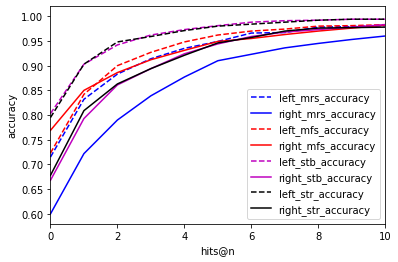

In [31]:
# Accuracy Plot
# namr format: "A_B_C". A: the side of data. B: the method od data. C:"accuracy"
names=["left_mrs_accuracy","right_mrs_accuracy",
       "left_mfs_accuracy","right_mfs_accuracy",
       "left_stb_accuracy","right_stb_accuracy",
       "left_str_accuracy","right_str_accuracy"]
contents=[left_mrs_accuracy,right_mrs_accuracy,
          left_mfs_accuracy,right_mfs_accuracy,
          left_stb_accuracy,right_stb_accuracy,
          left_str_accuracy,right_str_accuracy]

color_code = iter(list("bgrcmykw"))
name_types={}
for name, content in zip(names, contents):
    #check name type
    name_type = name.split("_")[1]
    name_side = name.split("_")[0]
    # define color type
    color_ = name_types.get(name_type,next(color_code))
    name_types[name_type] = color_
    
    # define line type
    if name_side=="right":
        line_type = "-"
    elif name_side=="left":
        line_type="--"
    else:
        line_type="*"
    
    plt.plot(content.keys(),content.values(),color_+line_type,label=name)
    
plt.xlabel('hits@n')
plt.ylabel('accuracy')
plt.xlim((0,10))
plt.legend()
plt.show()